## Курсовой проект

Ник на www.kaggle.com - dv-zheludkov

### Подключение библиотек, настройка, инициализация данных

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from lightgbm import LGBMRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

def look_in_features (el):
    plt.figure(figsize=(6, 3))
    sns.boxplot(el, whis=1.5)
    plt.show()
    print(el.value_counts())
    
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min = None
        self.districts_healthcare = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_max_value = X['KitchenSquare'].quantile(.98)
        self.kitchen_square_min_value = X['KitchenSquare'].quantile(.02)
        self.life_square_min = X['LifeSquare'].quantile(.05)
        self.districts_healthcare = X.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        condition = (X['Rooms'] > 6) | (X['Rooms'] == 0) 
        room_square = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        X.loc[condition, 'Rooms'] = X.loc[condition, 'LifeSquare'] / room_square
        
        #Square
        X['Square'], X['LifeSquare'] = np.where(X['Square'] < X['LifeSquare'], (X['LifeSquare'],X['Square']), (X['Square'],X['LifeSquare']))

        # KitchenSquare
        
        condition = (X['KitchenSquare'] > self.kitchen_square_max_value) | (X['KitchenSquare'] < self.kitchen_square_min_value)
        X.loc[condition, 'KitchenSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'LifeSquare'] \
        - (X.loc[condition, 'Square'] * 0.15)
        
        
        # HouseFloor, Floor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1
        condition = X['HouseFloor'] < X['Floor']
        X.loc[condition, 'HouseFloor'] = X.loc[condition, 'Floor']
        
        # HouseYear
        current_year = datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = random.randint(current_year - 20, current_year)
        
        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.districts_healthcare)
        condition = (X['Healthcare_1'].isna())     
        X.loc[condition, 'Healthcare_1'] = X['Healthcare_1'].median()
            
        # LifeSquare
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())        
        X['Square_to_LifeSquare'] = X['Square'] / X['LifeSquare']
        X.loc[condition, 'LifeSquare'] = X['Square'] / X['Square_to_LifeSquare'].quantile(.50)
        X.drop(['Square_to_LifeSquare'], axis = 1, inplace = True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.district_price_per_square = None
        self.median_district_price_per_square = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
                
        # Target encoding
        ## floor, year
        df = X.copy()
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / X.groupby(['DistrictId'])['Square'].agg('median')
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        self.district_price_per_square.to_dict()
        X['DistrictPrice'] = X['DistrictId'].map(self.district_price_per_square)
        self.median_district_price_per_square = X['DistrictPrice'].median()
        X['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)
        

        
        # More categorical features
       
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)

        return X
    
    def floor_to_cat(self, X):
        bins = [0, 4, 7, 10, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    

def model_score(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Предсказанные значения")
    plt.ylabel("Реальные значения")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f},   mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()
    
TRAIN_DATASET_PATH = 'train.csv.zip'
TEST_DATASET_PATH = 'test.csv'

In [2]:
train_df = pd.read_csv(TRAIN_DATASET_PATH,compression="zip")
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [3]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

### Анализ и подготовка данных

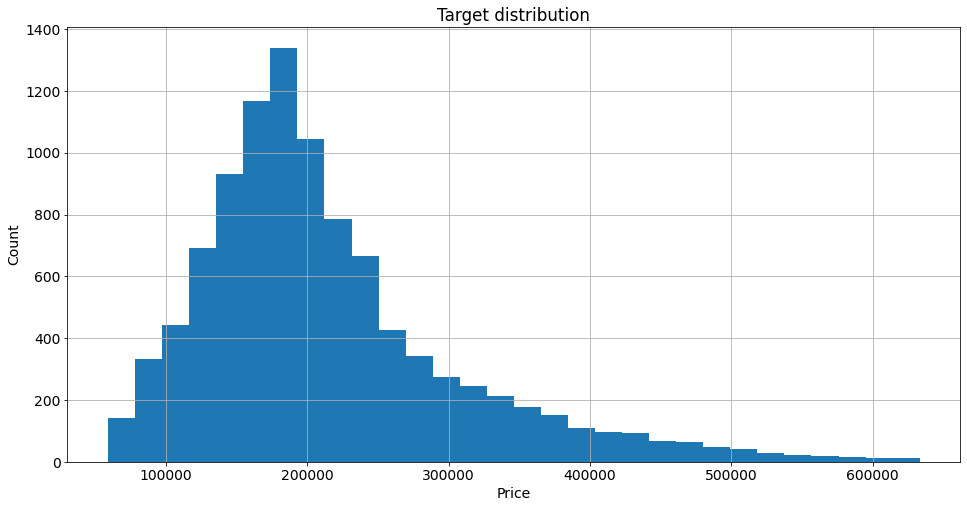

In [4]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

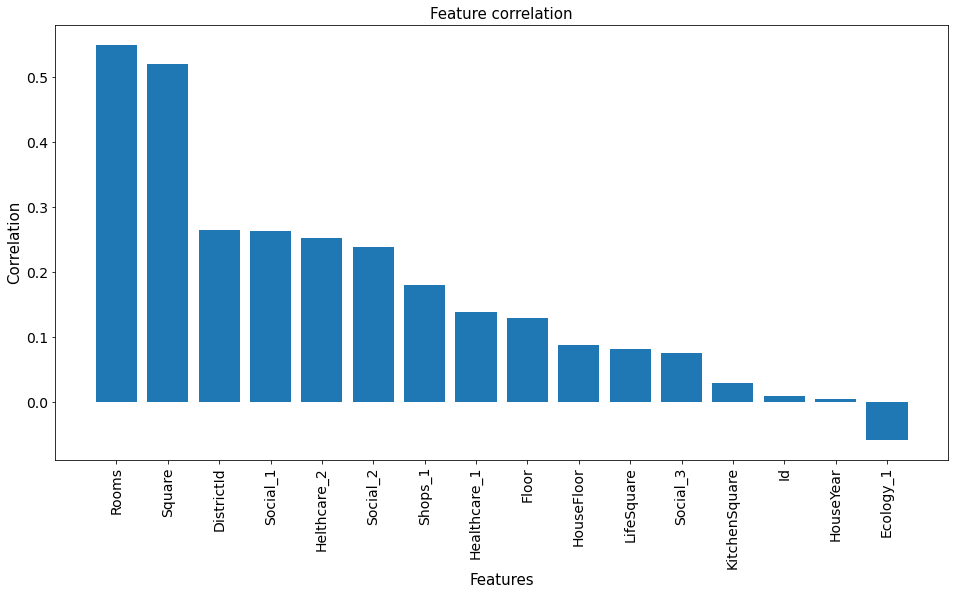

In [5]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [6]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315777,21.058731,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199646,86.241211,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01


In [7]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [8]:
#look_in_features(train_df['Square'])
#look_in_features(train_df['LifeSquare'])
#look_in_features(train_df['KitchenSquare'])
#train_df[train_df['Square'] < train_df['LifeSquare']]
#look_in_features(train_df['HouseFloor'])
#look_in_features(train_df['Floor'])
#look_in_features(train_df['HouseYear'])
#train_df.isna().sum()
#train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)


In [9]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['DistrictSize', 'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear']

target_name = 'Price'

In [10]:
train_df = pd.read_csv(TRAIN_DATASET_PATH,compression="zip")
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
X = train_df.drop('Price', axis = 1)
y = train_df['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


(0, 0, 0)

In [11]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

### Построение модели

In [12]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=3000, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.03)

In [13]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.03, loss='huber',
                          max_depth=5, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=3000, random_state=42)

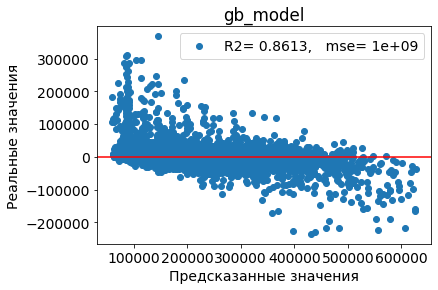

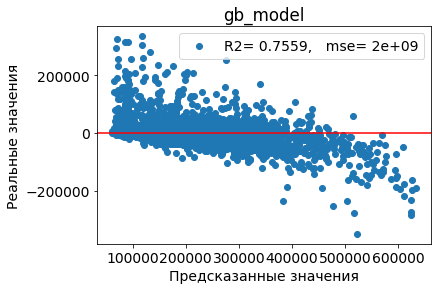

In [14]:
model_score(gb_model, 'gb_model', X_train, y_train)
model_score(gb_model, 'gb_model', X_valid, y_valid)

Модель GradientBoostingRegressor показала самый меньший разброс между значениями R2 на тесте и валидации. И в данном случае меньше всех склонна к переобучаемости.
Дальше подберем для нее лучшие параметры и построим итоговую модель

In [15]:
gb_model.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(criterion='mse', learning_rate=0.03, loss='huber',
                          max_depth=5, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=3000, random_state=42)>

Train R2:	0.861
Test R2:	0.756


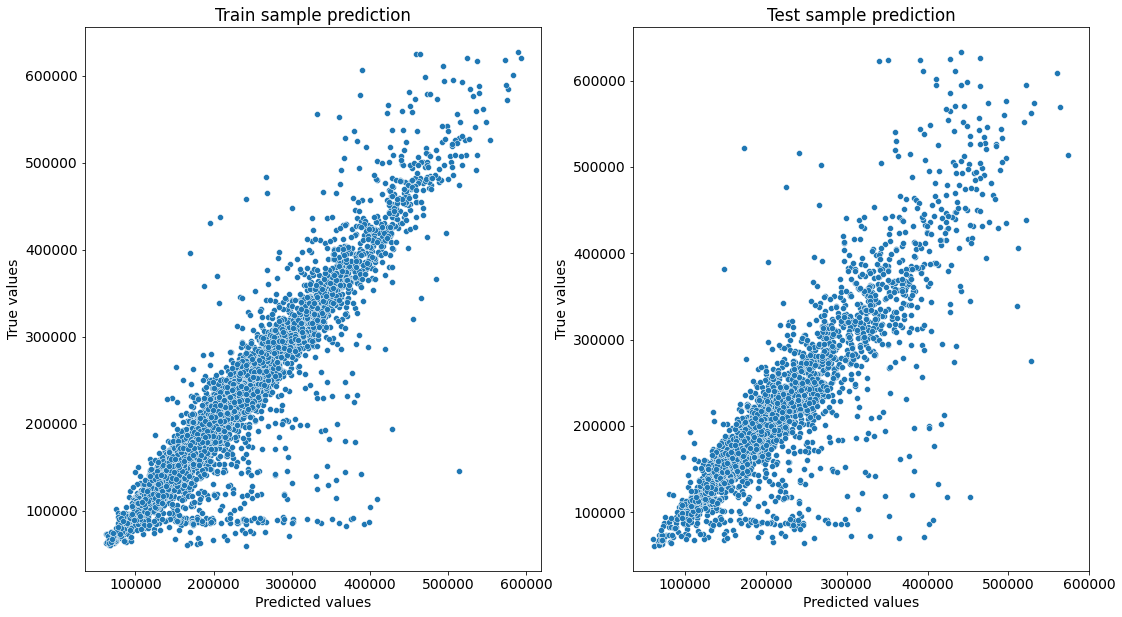

In [16]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [17]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72815592, 0.75628058, 0.75843916])

In [18]:
cv_score.mean()

0.7476252187337277

In [19]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
1,Square,0.228951
2,LifeSquare,0.125949
17,DistrictSize,0.112568
0,Rooms,0.102714
10,Social_1,0.051518
19,IsDistrictLarge,0.050642
11,Social_2,0.048833
12,Social_3,0.046901
3,KitchenSquare,0.037184
7,Ecology_1,0.032304


### Подготовка и сохранение данных

In [20]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [21]:
predictions = gb_model.predict(test_df)
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163566.434875
1,5925,127918.383469
2,960,135686.620210
3,3848,98502.551705
4,746,177934.967365


In [22]:
submit.to_csv('dv_zheludkov_submit.csv', index=False)